In [1]:
%matplotlib widget

# Part A Part 1

Below I implemented my own a Star algorithm, for demonstration and visual.  The timing studies below will instead be ran with the A star algorithm provided by the github repository, allowing for a more standardized approach to timing and measuring each method.

In [2]:
# Below is my implelmentation of A star

class Node():
    """A node class for A* Pathfinding"""

    def __init__(self, parent: 'tuple[int,int]'=None, position:'tuple[int,int]'=None):
        self.parent = parent
        self.position = position

        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.position == other.position
    

def astar(maze, start: tuple, end: tuple) -> list[tuple]:
    
    start_node = Node(None, start)
    goal_node = Node(None, end)
    
    open_list: 'list[Node]' = []
    close_list: 'list[Node]'  = []
    
    open_list.append(start_node)
    
    while open_list:
        
        # Find minimum f value in open list
        c_node = open_list[0]
        c_idx = 0
        for idx, item in enumerate(open_list):
            if item.f < c_node.f:
                c_node = item
                c_idx = idx
                
        # Clost lowest F
        close_list.append(open_list.pop(c_idx))
        
        # If end node is reached
        if c_node == goal_node:
            path = []
            
            c = c_node
            while c is not None:
                path.append(c.position)
                c = c.parent

            return path[::-1]
        
        # Generate children
        children = []
        for new_position in [(0, -1), (0, 1), (-1, 0), (1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]: # Adjacent squares

            # Get node position
            node_position = (c_node.position[0] + new_position[0], c_node.position[1] + new_position[1])

            # Make sure within range
            if node_position[0] > (len(maze) - 1) or node_position[0] < 0 or node_position[1] > (len(maze[len(maze)-1]) -1) or node_position[1] < 0:
                continue

            # Make sure walkable terrain
            if maze[node_position[0]][node_position[1]] != 0:
                continue

            # Create new node
            new_node = Node(c_node, node_position)

            # Append
            children.append(new_node)
            
            
        for child in children:
            if child in close_list:
                continue
            
            # Create the f, g, and h values
            child.g = c_node.g + 1
            child.h = ((child.position[0] - goal_node.position[0]) ** 2) + ((child.position[1] - goal_node.position[1]) ** 2)
            child.f = child.g + child.h

            # Child is already in the open list
            for open_node in open_list:
                if child == open_node and child.g > open_node.g:
                    continue

            # Add the child to the open list
            open_list.append(child)

In [3]:
maze =     [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

start = (0, 0)
end = (7, 6)

path = astar(maze, start, end)
print(path)

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 3), (5, 4), (6, 5), (7, 6)]


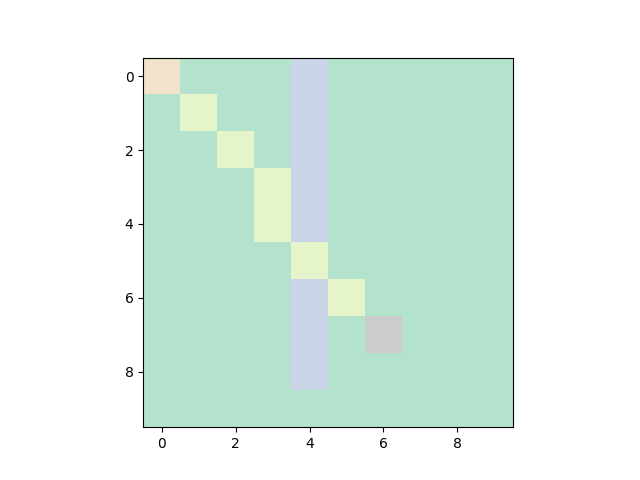

In [4]:
import matplotlib.pyplot as plt
def show_maze(init_maze, path, start, end):
    display = init_maze
    
    for x, y in path:
        display[x][y] = 2
    x, y = start
    display[x][y] = 3 
    x, y = end
    display[x][y] = 4
    plt.imshow(display, cmap='Pastel2')

show_maze(maze, path, start, end)

# Part A Part 2: Timing Study

In [5]:
# Planners below
import math
class BidirectionalAStarPlanner:
    def __init__(self, ox, oy, resolution, rr):
        """
        Initialize grid map for a star planning

        ox: x position list of Obstacles [m]
        oy: y position list of Obstacles [m]
        resolution: grid resolution [m]
        rr: robot radius[m]
        """

        self.min_x, self.min_y = None, None
        self.max_x, self.max_y = None, None
        self.x_width, self.y_width, self.obstacle_map = None, None, None
        self.resolution = resolution
        self.rr = rr
        self.calc_obstacle_map(ox, oy)
        self.motion = self.get_motion_model()

    class Node:
        def __init__(self, x, y, cost, parent_index):
            self.x = x  # index of grid
            self.y = y  # index of grid
            self.cost = cost
            self.parent_index = parent_index

        def __str__(self):
            return (
                str(self.x)
                + ","
                + str(self.y)
                + ","
                + str(self.cost)
                + ","
                + str(self.parent_index)
            )

    def planning(self, sx, sy, gx, gy):
        """
        Bidirectional A star path search

        input:
            s_x: start x position [m]
            s_y: start y position [m]
            gx: goal x position [m]
            gy: goal y position [m]

        output:
            rx: x position list of the final path
            ry: y position list of the final path
        """

        start_node = self.Node(
            self.calc_xy_index(sx, self.min_x),
            self.calc_xy_index(sy, self.min_y),
            0.0,
            -1,
        )
        goal_node = self.Node(
            self.calc_xy_index(gx, self.min_x),
            self.calc_xy_index(gy, self.min_y),
            0.0,
            -1,
        )

        open_set_A, closed_set_A = dict(), dict()
        open_set_B, closed_set_B = dict(), dict()
        open_set_A[self.calc_grid_index(start_node)] = start_node
        open_set_B[self.calc_grid_index(goal_node)] = goal_node

        current_A = start_node
        current_B = goal_node
        meet_point_A, meet_point_B = None, None

        while 1:
            if len(open_set_A) == 0:
                print("Open set A is empty..")
                break

            if len(open_set_B) == 0:
                print("Open set B is empty..")
                break

            c_id_A = min(
                open_set_A, key=lambda o: self.find_total_cost(open_set_A, o, current_B)
            )

            current_A = open_set_A[c_id_A]

            c_id_B = min(
                open_set_B, key=lambda o: self.find_total_cost(open_set_B, o, current_A)
            )

            current_B = open_set_B[c_id_B]

            # # show graph
            # if show_animation:  # pragma: no cover
            #     plt.plot(
            #         self.calc_grid_position(current_A.x, self.min_x),
            #         self.calc_grid_position(current_A.y, self.min_y),
            #         "xc",
            #     )
            #     plt.plot(
            #         self.calc_grid_position(current_B.x, self.min_x),
            #         self.calc_grid_position(current_B.y, self.min_y),
            #         "xc",
            #     )
            #     # for stopping simulation with the esc key.
            #     plt.gcf().canvas.mpl_connect(
            #         "key_release_event",
            #         lambda event: [exit(0) if event.key == "escape" else None],
            #     )
            #     if len(closed_set_A.keys()) % 10 == 0:
            #         plt.pause(0.001)

            if current_A.x == current_B.x and current_A.y == current_B.y:
                print("Found goal")
                meet_point_A = current_A
                meet_point_B = current_B
                break

            # Remove the item from the open set
            del open_set_A[c_id_A]
            del open_set_B[c_id_B]

            # Add it to the closed set
            closed_set_A[c_id_A] = current_A
            closed_set_B[c_id_B] = current_B

            # expand_grid search grid based on motion model
            for i, _ in enumerate(self.motion):

                c_nodes = [
                    self.Node(
                        current_A.x + self.motion[i][0],
                        current_A.y + self.motion[i][1],
                        current_A.cost + self.motion[i][2],
                        c_id_A,
                    ),
                    self.Node(
                        current_B.x + self.motion[i][0],
                        current_B.y + self.motion[i][1],
                        current_B.cost + self.motion[i][2],
                        c_id_B,
                    ),
                ]

                n_ids = [
                    self.calc_grid_index(c_nodes[0]),
                    self.calc_grid_index(c_nodes[1]),
                ]

                # If the node is not safe, do nothing
                continue_ = self.check_nodes_and_sets(
                    c_nodes, closed_set_A, closed_set_B, n_ids
                )

                if not continue_[0]:
                    if n_ids[0] not in open_set_A:
                        # discovered a new node
                        open_set_A[n_ids[0]] = c_nodes[0]
                    else:
                        if open_set_A[n_ids[0]].cost > c_nodes[0].cost:
                            # This path is the best until now. record it
                            open_set_A[n_ids[0]] = c_nodes[0]

                if not continue_[1]:
                    if n_ids[1] not in open_set_B:
                        # discovered a new node
                        open_set_B[n_ids[1]] = c_nodes[1]
                    else:
                        if open_set_B[n_ids[1]].cost > c_nodes[1].cost:
                            # This path is the best until now. record it
                            open_set_B[n_ids[1]] = c_nodes[1]

        rx, ry = self.calc_final_bidirectional_path(
            meet_point_A, meet_point_B, closed_set_A, closed_set_B
        )

        return rx, ry

    # takes two sets and two meeting nodes and return the optimal path
    def calc_final_bidirectional_path(self, n1, n2, setA, setB):
        rx_A, ry_A = self.calc_final_path(n1, setA)
        rx_B, ry_B = self.calc_final_path(n2, setB)

        rx_A.reverse()
        ry_A.reverse()

        rx = rx_A + rx_B
        ry = ry_A + ry_B

        return rx, ry

    def calc_final_path(self, goal_node, closed_set):
        # generate final course
        rx, ry = [self.calc_grid_position(goal_node.x, self.min_x)], [
            self.calc_grid_position(goal_node.y, self.min_y)
        ]
        parent_index = goal_node.parent_index
        while parent_index != -1:
            n = closed_set[parent_index]
            rx.append(self.calc_grid_position(n.x, self.min_x))
            ry.append(self.calc_grid_position(n.y, self.min_y))
            parent_index = n.parent_index

        return rx, ry

    def check_nodes_and_sets(self, c_nodes, closedSet_A, closedSet_B, n_ids):
        continue_ = [False, False]
        if not self.verify_node(c_nodes[0]) or n_ids[0] in closedSet_A:
            continue_[0] = True

        if not self.verify_node(c_nodes[1]) or n_ids[1] in closedSet_B:
            continue_[1] = True

        return continue_

    @staticmethod
    def calc_heuristic(n1, n2):
        w = 1.0  # weight of heuristic
        d = w * math.hypot(n1.x - n2.x, n1.y - n2.y)
        return d

    def find_total_cost(self, open_set, lambda_, n1):
        g_cost = open_set[lambda_].cost
        h_cost = self.calc_heuristic(n1, open_set[lambda_])
        f_cost = g_cost + h_cost
        return f_cost

    def calc_grid_position(self, index, min_position):
        """
        calc grid position

        :param index:
        :param min_position:
        :return:
        """
        pos = index * self.resolution + min_position
        return pos

    def calc_xy_index(self, position, min_pos):
        return round((position - min_pos) / self.resolution)

    def calc_grid_index(self, node):
        return (node.y - self.min_y) * self.x_width + (node.x - self.min_x)

    def verify_node(self, node):
        px = self.calc_grid_position(node.x, self.min_x)
        py = self.calc_grid_position(node.y, self.min_y)

        if px < self.min_x:
            return False
        elif py < self.min_y:
            return False
        elif px >= self.max_x:
            return False
        elif py >= self.max_y:
            return False

        # collision check
        if self.obstacle_map[node.x][node.y]:
            return False

        return True

    def calc_obstacle_map(self, ox, oy):

        self.min_x = round(min(ox))
        self.min_y = round(min(oy))
        self.max_x = round(max(ox))
        self.max_y = round(max(oy))
        print("min_x:", self.min_x)
        print("min_y:", self.min_y)
        print("max_x:", self.max_x)
        print("max_y:", self.max_y)

        self.x_width = round((self.max_x - self.min_x) / self.resolution)
        self.y_width = round((self.max_y - self.min_y) / self.resolution)
        print("x_width:", self.x_width)
        print("y_width:", self.y_width)

        # obstacle map generation
        self.obstacle_map = [
            [False for _ in range(self.y_width)] for _ in range(self.x_width)
        ]
        for ix in range(self.x_width):
            x = self.calc_grid_position(ix, self.min_x)
            for iy in range(self.y_width):
                y = self.calc_grid_position(iy, self.min_y)
                for iox, ioy in zip(ox, oy):
                    d = math.hypot(iox - x, ioy - y)
                    if d <= self.rr:
                        self.obstacle_map[ix][iy] = True
                        break

    @staticmethod
    def get_motion_model():
        # dx, dy, cost
        motion = [
            [1, 0, 1],
            [0, 1, 1],
            [-1, 0, 1],
            [0, -1, 1],
            [-1, -1, math.sqrt(2)],
            [-1, 1, math.sqrt(2)],
            [1, -1, math.sqrt(2)],
            [1, 1, math.sqrt(2)],
        ]

        return motion


min_x: -10
min_y: -10
max_x: 60
max_y: 60
x_width: 35
y_width: 35
Found goal
([10.0, 12.0, 12.0, 14.0, 16.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 20.0, 22.0, 24.0, 26.0, 26.0, 26.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 38.0, 40.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 44.0, 44.0, 46.0, 48.0, 48.0, 50.0], [10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 38.0, 40.0, 42.0, 40.0, 38.0, 36.0, 34.0, 34.0, 32.0, 30.0, 28.0, 26.0, 24.0, 22.0, 20.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 46.0, 48.0, 50.0])


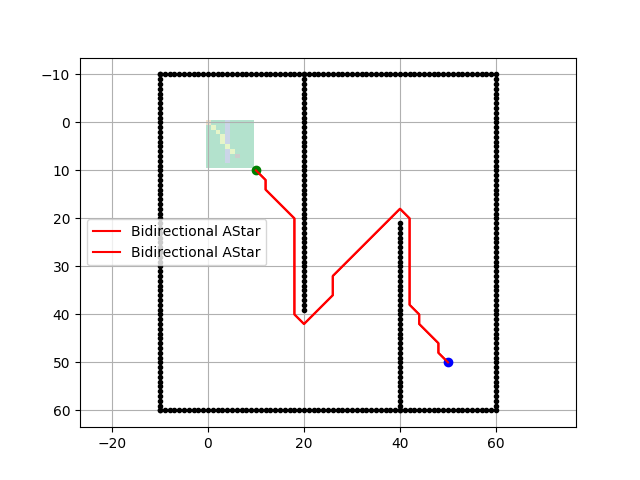

In [7]:
show_animation = True

sx = 10.0  # [m]
sy = 10.0  # [m]
gx = 50.0  # [m]
gy = 50.0  # [m]
grid_size = 2.0  # [m]
robot_radius = 1.0  # [m]

# set obstacle positions
ox, oy = [], []
for i in range(-10, 60):
    ox.append(i)
    oy.append(-10.0)
for i in range(-10, 60):
    ox.append(60.0)
    oy.append(i)
for i in range(-10, 61):
    ox.append(i)
    oy.append(60.0)
for i in range(-10, 61):
    ox.append(-10.0)
    oy.append(i)
for i in range(-10, 40):
    ox.append(20.0)
    oy.append(i)
for i in range(0, 40):
    ox.append(40.0)
    oy.append(60.0 - i)

if show_animation:  # pragma: no cover
    plt.plot(ox, oy, ".k")
    plt.plot(sx, sy, "og")
    plt.plot(gx, gy, "ob")
    plt.grid(True)
    plt.axis("equal")
    
paths = []

bidir_a_star = BidirectionalAStarPlanner(ox, oy, grid_size, robot_radius)
paths.append(bidir_a_star.planning(sx, sy, gx, gy))

if show_animation:  # pragma: no cover
    for path in paths:
        print(path)
        plt.plot(path[0], path[1], "-r", label="Bidirectional AStar")
        plt.legend()
        plt.show()